In [1]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def correlate(e1, e2=None):
    if e2 is None:
        e2 = e1
    return e1 @ e2.T

def correlate_minus_diag(e1):
    correlation = e1 @ e1.T
    return correlation - (1 - correlation.mean()) * np.eye(correlation.shape[0])

with open('.env') as f:
    openai.api_key = f.read().strip().split('=')[1]

anthems_dir = Path('data/anthems')
file_paths = {}
lyrics = {}
embeddings = {}

for g in anthems_dir.glob('*.txt'):
    stem = g.stem
    file_paths[stem] = g
    
    with open(g) as f:
        lyrics[stem] = np.asarray([line.strip() for line in f.readlines() if line.strip() != ""])

    emb_path = g.with_suffix('.emb')
    if os.path.isfile(emb_path):
        print(f"Loading {stem} from file")
        embeddings[stem] = np.loadtxt(emb_path)
    else:
        print(f"Fetching {stem} from OpenAI")
        response = openai.Embedding.create(input=list(lyrics[stem]), model="text-embedding-ada-002")
        embeddings[stem] = np.asarray([e.embedding for e in response['data']])
        np.savetxt(emb_path, embeddings[stem])

Loading USA from file
Loading RUS from file
Loading CAN from file
Loading GBR from file
Loading NZL from file
Loading PRK from file
Loading AUS from file
Loading KOR from file


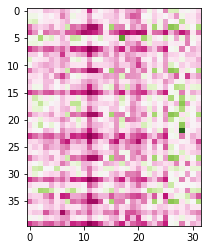

In [112]:
plt.imshow(correlate(embeddings['NZL'], embeddings['USA']), cmap='PiYG')

In [115]:
country1 = 'USA'
country2 = 'NZL'
c = correlate(embeddings[country1], embeddings[country2])
idx1, idx2 = np.unravel_index(c.argmax(), c.shape)

print(c.max())

lyrics[country1][idx1], lyrics[country2][idx2]

0.9109301072673278


('Then conquer we must, when our cause it is just,',
 'Let our cause be just and right,')

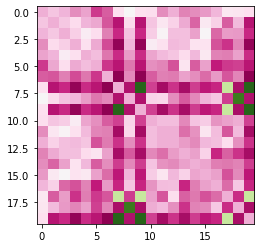

In [116]:
plt.imshow(correlate_minus_diag(embeddings['AUS']), cmap='PiYG')

(array([ 56.,  90., 124.,  78.,  38.,   0.,   6.,   0.,   0.,   8.]),
 array([0.73838607, 0.76454747, 0.79070886, 0.81687026, 0.84303165,
        0.86919305, 0.89535445, 0.92151584, 0.94767724, 0.97383863,
        1.00000003]),
 <BarContainer object of 10 artists>)

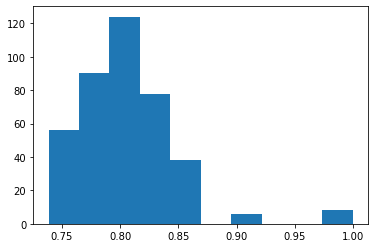

In [118]:
plt.hist(correlate_minus_diag(embeddings['AUS']).ravel())

In [119]:
for key in embeddings.keys():
    print(key, embeddings[key].shape)

USA (32, 1536)
RUS (20, 1536)
CAN (10, 1536)
GBR (21, 1536)
NZL (40, 1536)
PRK (24, 1536)
AUS (20, 1536)
KOR (16, 1536)


In [43]:
anglo_countries = ['USA', 'CAN', 'GBR', 'AUS', 'NZL']

anglo_lyrics = pd.concat(pd.DataFrame({'lyric': lyrics[country], 'country': country}).reset_index().set_index(['country', 'index']) for country in anglo_countries)
anglo_embeddings = np.vstack([embeddings[country] for country in anglo_countries])

print(len(anglo_lyrics))
print(anglo_embeddings.shape)

123
(123, 1536)


In [44]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(anglo_embeddings)
anglo['cluster'] = kmeans.labels_
anglo

lyric  cluster
country index                                                            
USA     0          O say can you see, by the dawn's early light,        1
        1      What so proudly we hailed at the twilight's la...        4
        2      Whose broad stripes and bright stars through t...        4
        3      O'er the ramparts we watched, were so gallantl...        4
        4      And the rocket's red glare, the bombs bursting...        4
...                                                          ...      ...
NZL     35                             God defend our free land.        3
        36                        Guide her in the nations' van,        2
        37                      Preaching love and truth to man,        1
        38                        Working out Thy glorious plan,        2
        39                               God defend New Zealand.        3

[123 rows x 2 columns]

In [49]:
anglo[anglo['cluster'] == 4]

lyric  cluster
country index                                                            
USA     1      What so proudly we hailed at the twilight's la...        4
        2      Whose broad stripes and bright stars through t...        4
        3      O'er the ramparts we watched, were so gallantl...        4
        4      And the rocket's red glare, the bombs bursting...        4
        5      Gave proof through the night that our flag was...        4
        6          O say does that star-spangled banner yet wave        4
        7      O'er the land of the free and the home of the ...        4
        10     What is that which the breeze, o'er the toweri...        4
        11     As it fitfully blows, half conceals, half disc...        4
        14     'Tis the star-spangled banner, O long may it wave        4
        15     O'er the land of the free and the home of the ...        4
        16        And where is that band who so vauntingly swore        4
        18        A home and a country, should leave us no more?        4
        19     Their blood has washed out their foul footstep...        4
        20           No refuge could save the hireling and slave        4
        22     And the star-spangled banner in triumph doth w...        4
        23     O'er the land of the free and the home of the ...        4
        24           O thus be it ever, when freemen shall stand        4
        25     Between their loved homes and the war's desola...        4
        30     And the star-spangled banner in triumph shall ...        4
        31     O'er the land of the free and the home of the ...        4
CAN     1                              Our home and native land!        4
        4                        The True North strong and free!        4
AUS     14                 For those who’ve come across the seas        4
NZL     33                        Freedom's ramparts on the sea,        4

In [66]:

mpl.cm.get_cmap('tab10', 10)(10)

(0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

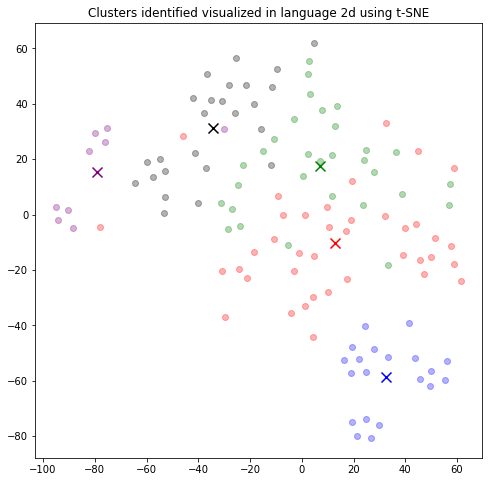

In [79]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(anglo_embeddings)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

fig, ax = plt.subplots(figsize=(8,8))

for category, color in enumerate(["purple", "green", "red", "blue", "black"]):
    xs = np.array(x)[anglo.cluster == category]
    ys = np.array(y)[anglo.cluster == category]
    ax.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    ax.scatter(avg_x, avg_y, marker="x", color=color, s=100)
ax.set_title("Clusters identified visualized in language 2d using t-SNE")

In [80]:
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    lyrics = "\n".join(
        anglo[anglo.cluster == i]
        .lyric
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following lyrics have in common?\n\nLyrics:\n"""\n{lyrics}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = anglo[anglo.cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.lyric.values[j])

    print("-" * 100)

Cluster 0 Theme:  Patriotism and national pride
Advance Australia fair!
O Canada, we stand on guard for thee.
Advance Australia fair!
O Canada!
Guard Pacific's triple star
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  The celebration of Australia's natural beauty and peacefulness.
Peace, not war, shall be our boast,
Our home is girt by sea;
In joyful strains then let us sing
Of beauty rich and rare;
From far and wide,
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  Patriotism and loyalty to God
Guard our country's spotless name,
Make us faithful unto Thee,
O Lord our God arise,
For we are one and free;
Let our love for Thee increase,
----------------------------------------------------------------------------------------------------
Cluster 3 Theme:  Patriotism and national pride
Blest with vict'ry and peace, may the Heav'n rescued land
God def